In [1]:
!pip install requests_html
!pip install yahoo_fin

     |████████████████████████████████| 153kB 7.2MB/s 
     |████████████████████████████████| 71kB 6.2MB/s 
     |████████████████████████████████| 133kB 13.0MB/s 
     |████████████████████████████████| 81kB 7.0MB/s 
  Created wheel for parse: filename=parse-1.18.0-cp36-none-any.whl size=24133 sha256=0a5f57bef5ce89a0d2919e64e73700ba8b408a097f52aeb235502b97cd710df2
  Stored in directory: /root/.cache/pip/wheels/2a/53/09/869ca5781ede342254ffac09ca99461b008c3e5f8dd079b0c0
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-cp36-none-any.whl size=13485 sha256=c359635588f1e9e93d2aa348d5db6c76b8c3173caf9d0bdfb0322cea27929d5b
  Stored in directory: /root/.cache/pip/wheels/5e/63/09/d1dc15179f175357d3f5c00cbffbac37f9e8690d80545143ff
Successfully built parse fake-useragent
ERROR: kaggle 1.5.8 has requirement urllib3<1.25,>=1.21.1, but you'll have urllib3 1.25.10 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is 

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random

In [11]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [23]:
import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.replace('\n','')
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

t = save_sp500_tickers()

#t = ['BKR','BWA','C','CAH','CBRE','CF','CMCSA','CTVA','DISCA','DRI','DVN','FANG','FITB','HAL','HBAN','HCA','HPE','LB','MET','MOS','MPC','PNC','SYF','TPR','WDC']
#t = ['VBIAX','VPGDX','VGSTX','VTMFX','VWINX','VWELX','VGWIX','VGWLX']
t = ['VFIAX','VBIAX','VHYAX','VFIFX','USMV','VTI']
t=['AAPL']
print(t)

['AAPL']


In [24]:
import keras
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [25]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=30, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 59 (that is 50+10-1) length
    # this last_sequence will be used to predict in future dates that are not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    # shift the last sequence by -1
    last_sequence = np.array(pd.DataFrame(last_sequence).shift(-1).dropna())
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    # return the result
    return result

In [26]:
def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_squared_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_squared_error"], optimizer=optimizer)
    return model

In [27]:
# Window size or the sequence length
N_STEPS = 100
# Lookup step, 1 is the next day
LOOKUP_STEP = 30
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.4
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 16
EPOCHS = 100

In [28]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [29]:
def predict(model, data, classification=False):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][:N_STEPS]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price

def get_accuracy(model, data):
  y_test = data["y_test"]
  X_test = data["X_test"]
  y_pred = model.predict(X_test)
  y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
  y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
  y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
  y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
  return accuracy_score(y_test, y_pred)

def plot_graph(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    # last 200 days, feel free to edit that
    plt.plot(y_test[-200:], c='b')
    plt.plot(y_pred[-200:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

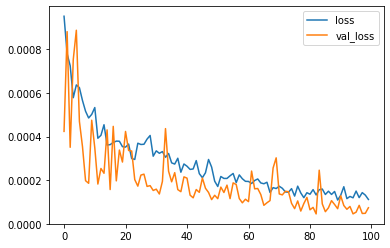

372/372 [==============================] - 24s 65ms/step - loss: 1.1138e-04 - mean_squared_error: 2.2276e-04 - val_loss: 7.3359e-05 - val_mean_squared_error: 1.4672e-04

Price vs Day Prediction for AAPL:


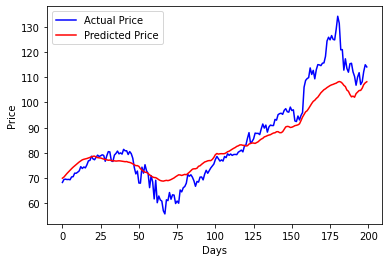

,Future Price,Price Change,Accuracy,MAE,MSE
AAPL,108.436,-6.11375,0.574771,0.0865862,0.0626648


In [30]:
from IPython.display import clear_output

columns = ['Future Price','Price Change','Accuracy','MAE','MSE']
dfstock = pd.DataFrame(index=t,columns=columns)

for ticker in t:
  ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
  # model name to save, making it as unique as possible based on parameters
  #model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
  model_name = f"{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
  if BIDIRECTIONAL:
      model_name += "-b"
  # load the data
  data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)

  # save the dataframe
  data["df"].to_csv(ticker_data_filename)

  # construct the model
  model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                      dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

  # some tensorflow callbacks
  checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
  tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

  history = model.fit(data["X_train"], data["y_train"],
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(data["X_test"], data["y_test"]),
                      callbacks=[plot_losses],
                      verbose=1)
  
  model.save(os.path.join("results", model_name) + ".h5")

  data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)

  # construct the model
  model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                      dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

  model_path = os.path.join("results", model_name) + ".h5"
  model.load_weights(model_path)

  # evaluate the model
  mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
  # calculate the mean absolute error (inverse scaling)
  mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
  mean_squared_error = data["column_scaler"]["adjclose"].inverse_transform([[mse]])[0][0]
  future_price = predict(model, data)
  accuracy = get_accuracy(model, data)
  price_change = future_price - data['df'].iloc[[-1]]['open'][0]
  dfstock.loc[ticker] = pd.Series({'Future Price':future_price, 'Price Change':price_change, 'Accuracy':accuracy, 'MAE':mean_absolute_error, 'MSE':mean_squared_error})
  print()
  print('Price vs Day Prediction for ' + ticker + ':')
  plot_graph(model, data)

dfstock